## Dataset Setup

In [1]:
import pathlib, os, sys, operator, re, datetime
from functools import reduce
import numpy as np
import tensorflow as tf
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import Model
import tensorflow_datasets as tfds
from tiny_imagenet import TinyImagenetDataset

# Enable or disable GPU
# To fully disable it, we need to hide all GPU devices from Tensorflow
# Make sure GPU is disabled for this inference part of the lab
ENABLE_GPU = True
# tf.debugging.set_log_device_placement(True)

if not ENABLE_GPU:
    tf.config.set_visible_devices([], 'GPU')

# Print Python and TF version, and where we are running
print(f'Running on Python Version: {sys.version}')
print(f'Using Tensorflow Version: {tf. __version__}')
if not tf.config.experimental.list_physical_devices("GPU"):
    print('Running on CPU')
else:
    print(f'Using GPU at: {tf.test.gpu_device_name()} (of {len(tf.config.experimental.list_physical_devices("GPU"))} available)')

Running on Python Version: 3.6.8 (default, May 31 2023, 10:28:59) 
[GCC 8.5.0 20210514 (Red Hat 8.5.0-18)]
Using Tensorflow Version: 2.6.2
Using GPU at: /device:GPU:0 (of 1 available)


In [2]:
# Original Source: https://github.com/ksachdeva/tiny-imagenet-tfds
# Class Version Source: https://github.com/Mluckydwyer/tiny-imagenet-tfds
# Setup our dataset
# ---------------------------------------------------------

tiny_imagenet_builder = TinyImagenetDataset()

# this call (download_and_prepare) will trigger the download of the dataset
# and preparation (conversion to tfrecords)
#
# This will be done only once and on next usage tfds will
# use the cached version on your host.
tiny_imagenet_builder.download_and_prepare(download_dir="~/tensorflow-datasets/downloads")

# class_names = tiny_imagenet_builder.info.features['label'].names
ds = tiny_imagenet_builder.as_dataset()
ds_train, ds_val = ds["train"], ds["validation"]
assert(isinstance(ds_train, tf.data.Dataset))
assert(isinstance(ds_val, tf.data.Dataset))

# Training Dataset
ds_train = ds_train.shuffle(1024).prefetch(tf.data.AUTOTUNE)

# Validation Dataset
ds_val = ds_val.shuffle(1024).prefetch(tf.data.AUTOTUNE)

# Dataset metadata
ds_info = tiny_imagenet_builder.info

## Working with the Dataset

In [3]:
# Helper function to get the label name
def img_class(img_data, idx=None):
    image, label, id, label_name = img_data["image"], img_data["label"], img_data["id"], img_data["metadata"]['label_name']
    # Handle batches of images correctly
    if idx != None:
        image, label, id, label_name = img_data["image"][idx], img_data["label"][idx], img_data["id"][idx], img_data["metadata"]['label_name'][idx]
    
    return f"{label_name} (class index: {label} - id: {id})"


# Helper function to show basic info about an image
def img_info(img, idx=None, display=True, title_apend=""):
    image = img['image']

    # Print the clas
    class_str = img_class(img, idx)
    print(f"Label: {class_str}")
    
    # Display the image
    if display:
        plt.figure()
        plt.title(title_apend + class_str)
        # Handle batches correctly
        if image.shape.ndims > 3:
            plt.imshow(image.numpy().reshape(64, 64, 3))
        else:
            plt.imshow(image.numpy())

--- Train & Validation dataset info ---
Train: <PrefetchDataset shapes: {id: (), image: (64, 64, 3), label: (), metadata: {label_name: ()}}, types: {id: tf.string, image: tf.uint8, label: tf.int64, metadata: {label_name: tf.string}}>
Validation: <PrefetchDataset shapes: {id: (), image: (64, 64, 3), label: (), metadata: {label_name: ()}}, types: {id: tf.string, image: tf.uint8, label: tf.int64, metadata: {label_name: tf.string}}>

--- Show an example image ---
Label: b'walking stick, walkingstick, stick insect' (class index: 181 - id: b'n02231487')

 Show some other examples


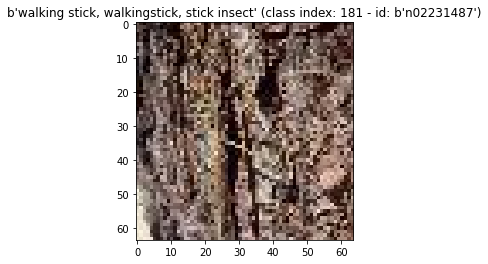

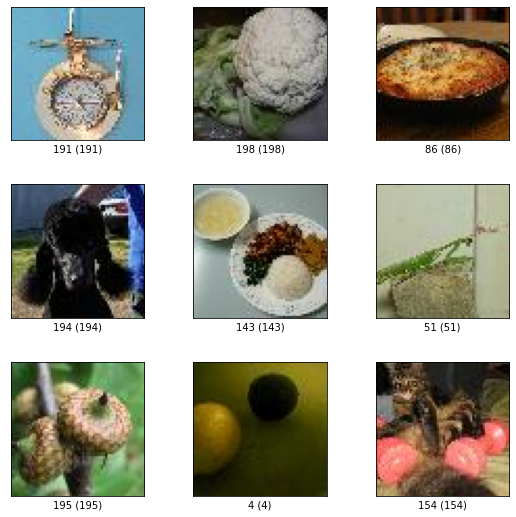

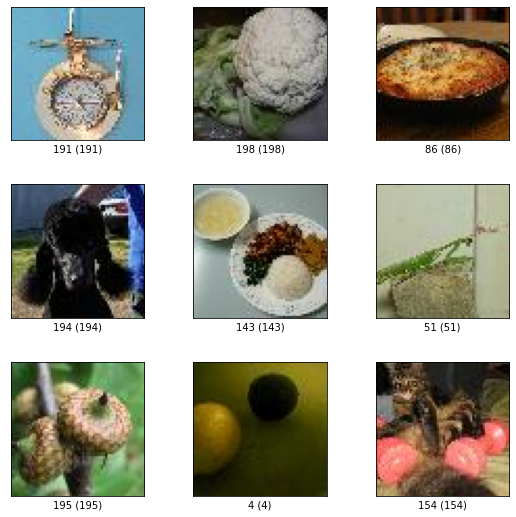

In [4]:
# Print the dataset types and info
print("--- Train & Validation dataset info ---")
print(f"Train: {ds_train}")
print(f"Validation: {ds_val}")
# print(f"Dataset Info: {ds_info}") # Uncomment to print Dataset info

print("\n--- Show an example image ---")
for example in ds_val.take(1):
    img_info(example)

print("\n Show some other examples")
tfds.show_examples(ds_val, ds_info, rows=3, cols=3)


--- Image 0 ---
Image Data Type: <dtype: 'uint8'>
Image Shape: (64, 64, 3)
Image Memory: 12288 bytes
Label: b'iPod' (class index: 91 - id: b'n03584254')

--- Image 1 ---
Image Data Type: <dtype: 'uint8'>
Image Shape: (64, 64, 3)
Image Memory: 12288 bytes
Label: b'neck brace' (class index: 81 - id: b'n03814639')

--- Image 2 ---
Image Data Type: <dtype: 'uint8'>
Image Shape: (64, 64, 3)
Image Memory: 12288 bytes
Label: b'rocking chair, rocker' (class index: 3 - id: b'n04099969')


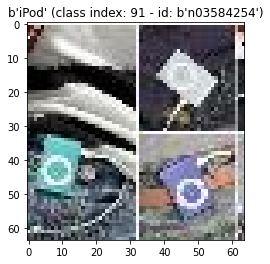

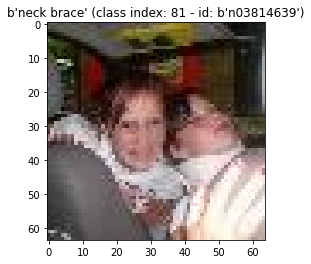

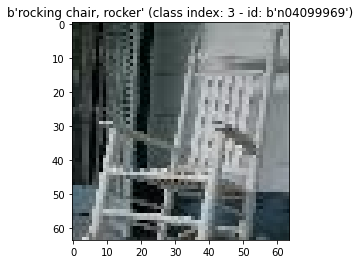

In [5]:
#     : Print and visualize three inputs from the validation set
#     : Print the storage data type
#     : Print and note the dimensions of each image
#     : Print the memory required to store each image

# Sample Images
sample_imgs = []
for index, img_data in enumerate(ds_val.take(3)):
    sample_imgs.append(img_data)
    image, label, id, label_name = img_data["image"], img_data["label"], img_data["id"], img_data["metadata"]['label_name']

    print(f'\n--- Image {index} ---')
    # Your Code Here
    print(f"Image Data Type: {image.dtype}")
    print(f"Image Shape: {image.shape}")
    print(f"Image Memory: {image.numpy().nbytes} bytes")
    img_info(img_data)

In [6]:
# Export each of the three inputs to a binary file which will be used to load the images into C++ later
# NOTE: First flatten the array (ex: 4D --> 1D). So 64*64*3 = 12288 element 1D array

# Make a directory for our image data
img_dir = os.path.abspath('data_elu')
pathlib.Path(img_dir).mkdir(exist_ok=True)

# Create a metadata file
metadata_file = open(os.path.join(img_dir, f'metadata.txt'), 'w')
metadata_file.write(f'Number\t\tDims\t\tClass Data\n')

# Export each image
for index, img_data in enumerate(sample_imgs):
    img_file = open(os.path.join(img_dir, f'image_{index}.bin'), 'wb')
    
    # Your Code Here
    # Flatten the image
    image = img_data["image"].numpy().flatten()
    # Write the image to the file
    img_file.write(image)
    img_file.close()

    # Write the image metadata for reference later
    class_str = img_class(img_data)
    metadata_file.write(f'{index}\t\t{img_data["image"].shape}\t\t{class_str}\n')
metadata_file.close()

In [7]:
# define function to print top n accuracy
def print_top_n_accuracy(n, ds_val, model, batch_size=32):
    total = acc_top_n = 0

    for batch in ds_val.batch(batch_size):
        # Make a prediction
        pred = model.predict(batch["image"].numpy())
        top_n = tf.math.top_k(pred, k=n).indices
        
        # np.isin() returns a boolean array where the value is True if the element of the first input is in the second input
        # np.sum() sums the boolean array, which is the same as counting the number of True values
        acc_top_n += np.sum(np.isin(batch["label"].numpy(), top_n))
        
        total += len(batch["label"].numpy())

    print(f'Top-{n} Accuracy: {acc_top_n / total}, total images: {total}')


In [8]:
# Print all of the possible classes of the dataset and report how many there are in each split (train + validation)

# count all the unique classes in a dataset
def count_class(ds):
    class_count = {}
    num_unique = 0
    for img_data in ds:
        label = img_data["label"].numpy()
        if label in class_count:
            class_count[label] += 1
        else:
            class_count[label] = 1
            num_unique += 1
    return class_count, num_unique

# sum the class counts for each split
class_counts_train, count_unique_train = count_class(ds_train)
class_counts_val, count_unique_val = count_class(ds_val)

# Print all the classes present in the entire dataset
print(f'Entire dataset class IDs: {ds_info.features["label"].names}')
print(f'Number of classes in entire dataset: {len(ds_info.features["label"].names)}')

# Print the number of classes in each split
print(f'Number of unique Classes in Train: {count_unique_train}')
print(f'Number of unique Classes in Validation: {count_unique_val}')

# print the total number of images in the dataset
# print(f'Total number of images in dataset: {ds_info.splits["train"].num_examples + ds_info.splits["validation"].num_examples}')
print(f'Total number of images in dataset: {len(ds_train) + len(ds_val)}')


Entire dataset class IDs: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '150', '151', '152', '153', '154'

## Model Creation and Training

In [9]:
# Setup for model training
from tensorflow.keras import Model, datasets
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Dense, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, ZeroPadding2D,Convolution2D, Activation, Dropout 

train_dir = os.path.abspath(os.path.join('temp/train_data_elu', datetime.datetime.now().strftime("%Y%m%d-%H%M%S")))
pathlib.Path(train_dir).mkdir(exist_ok=True, parents=True)

# Using early stopping to monitor validation accuracy
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        # Stop training when `val_loss` is no longer improving
        monitor="val_loss",
        # "no longer improving" being defined as "no better than 1e-2 less"
        min_delta=1e-4,
        # "no longer improving" being further defined as "for at least 2 epochs"
        patience=3,
        verbose=1,
    ),
    tf.keras.callbacks.TensorBoard(log_dir=train_dir, histogram_freq=1)
]

log_dir = os.path.abspath(os.path.join('temp/log_data_elu', datetime.datetime.now().strftime("%Y%m%d-%H%M%S")))
pathlib.Path(log_dir).mkdir(exist_ok=True, parents=True)


In [10]:
# Basic CNN model
model = Sequential()

# conv1
model.add(Conv2D(32, (5, 5), input_shape=(64, 64, 3), activation='elu'))
model.add(Conv2D(32, (5,5),activation='elu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3,3), activation='elu'))
model.add(Conv2D(64, (3,3), activation='elu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3,3), activation='elu'))
model.add(Conv2D(128, (3,3), activation='elu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())

# fc1
model.add(Dense(256, activation='elu'))

# fc2
model.add(Dense(200, activation='softmax'))

# changed optimizer so we can run 30 epochs and not stop early due to early stopping
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 60, 60, 32)        2432      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 56, 56, 32)        25632     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 26, 26, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 10, 10, 64)        3

In [11]:
# Train the model
def normalize_img(image, label):
    return tf.cast(image, tf.float32) / 255., label


def to_categorical(image, label):
    label = tf.one_hot(tf.cast(label, tf.int32), 200)
    return tf.cast(image, tf.float32), tf.cast(label, tf.int64)


ds_re = tiny_imagenet_builder.as_dataset(as_supervised=True)
ds_retrain, ds_reval = ds_re["train"], ds_re["validation"]

ds_retrain = ds_retrain.cache().shuffle(1024)
ds_reval = ds_reval.cache().shuffle(1024)
# print(ds_reval)

ds_retrain = ds_retrain.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_reval = ds_reval.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)

ds_retrain = ds_retrain.map(
    to_categorical, num_parallel_calls=tf.data.AUTOTUNE)
ds_reval = ds_reval.map(to_categorical, num_parallel_calls=tf.data.AUTOTUNE)

epoch_size = 16
batch_size = 64
# print(ds_reval)

# save weights before training
init_weights = model.get_weights()

# Setup our batched datasets
ds_retrain_batched = ds_retrain.batch(batch_size)
ds_reval_batched = ds_reval.batch(batch_size)

# Run training
model.fit(ds_retrain_batched, epochs=epoch_size,
          validation_data=ds_reval_batched, callbacks=callbacks)

# Save the cnn model
model.save(os.path.join(
    log_dir, f'CNN_TinyImageNet_train_batch{batch_size}.h5'))

# Get the top-1 and top-5 of your newly trained model
print_top_n_accuracy(1, ds_val, model, batch_size)
print_top_n_accuracy(5, ds_val, model, batch_size)

print("Done!")


Epoch 1/16
1563/1563 [==============================] - 14s 8ms/step - loss: 4.4418 - accuracy: 0.0944 - val_loss: 3.9944 - val_accuracy: 0.1442
Epoch 2/16
1563/1563 [==============================] - 12s 8ms/step - loss: 3.8016 - accuracy: 0.1814 - val_loss: 3.8504 - val_accuracy: 0.1812
Epoch 3/16
1563/1563 [==============================] - 12s 7ms/step - loss: 3.4786 - accuracy: 0.2321 - val_loss: 3.7839 - val_accuracy: 0.1883
Epoch 4/16
1563/1563 [==============================] - 12s 7ms/step - loss: 3.2070 - accuracy: 0.2763 - val_loss: 3.8590 - val_accuracy: 0.1931
Epoch 5/16
1563/1563 [==============================] - 12s 8ms/step - loss: 2.9447 - accuracy: 0.3211 - val_loss: 4.0241 - val_accuracy: 0.1872
Epoch 6/16
1563/1563 [==============================] - 12s 8ms/step - loss: 2.7049 - accuracy: 0.3609 - val_loss: 4.2839 - val_accuracy: 0.1847
Epoch 00006: early stopping
Top-1 Accuracy: 0.0543, total images: 10000
Top-5 Accuracy: 0.1422, total images: 10000
Done!


## Export Weights and Layer Output Data

In [12]:
# Export the filters/weights se we can use them later
# Make a directory for our image data
model_dir = os.path.abspath('data_elu/model')
pathlib.Path(model_dir).mkdir(exist_ok=True)


# Export each image
conv_index = dense_index = 1 # layer index starts from one
for layer_idx, layer in enumerate(model.layers):
    if re.match("conv", layer.name):
        weight_file_name = os.path.join(model_dir, f'conv{conv_index}_weights.bin')
        bias_file_name = os.path.join(model_dir, f'conv{conv_index}_bias.bin')
        conv_index += 1
    elif re.match("dense", layer.name):
        weight_file_name = os.path.join(model_dir, f'dense{dense_index}_weights.bin')
        bias_file_name = os.path.join(model_dir, f'dense{dense_index}_bias.bin')
        dense_index += 1
    else:
        continue
    # Flatten the image
    weights = layer.get_weights()[0].flatten()
    biases = layer.get_weights()[1].flatten()
    # Write the image to the file
    weight_file = open(weight_file_name, 'wb')
    weight_file.write(weights)
    weight_file.close()
    
    bias_file = open(bias_file_name, 'wb')
    bias_file.write(biases)
    bias_file.close()

print(f"All the convolution and dense (fully connected) weights and biases successfully exported to input folders in {model_dir} directory")

All the convolution and dense (fully connected) weights and biases successfully exported to input folders in /home/sszabo/github/CPRE587/lab2/data_elu/model directory


In [13]:
# Export the intermediate layer outputs for each of the input for all of the layers
img_dir = os.path.abspath('data_elu')
pathlib.Path(img_dir).mkdir(exist_ok=True)

for img_idx, img in enumerate(sample_imgs):
    file_dir = os.path.join(img_dir, f'image_{img_idx}_data')
    pathlib.Path(file_dir).mkdir(exist_ok=True)
    
    for layer_idx, layer in enumerate(model.layers):
        aux_model = tf.keras.Model(inputs=model.inputs, outputs=[layer.output])
        
        # Store the intermediate output
        output = aux_model.predict(img["image"].numpy().reshape(1, 64, 64, 3))
        output_file_name = os.path.join(file_dir, f'layer_{layer_idx}_output.bin')
        output_file = open(output_file_name, 'wb')
        output_file.write(output)
        output_file.close()

print(f"All the corresponding intermediate layer outputs successfully exported to each input folder in the {img_dir} directory")


All the corresponding intermediate layer outputs successfully exported to each input folder in the /home/sszabo/github/CPRE587/lab2/data_elu directory
